In [1]:
import pandas as pd
import numpy as np
import random 
import torch
import os
import joblib
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine, pdist, squareform
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import Isomap, MDS, TSNE
from scipy.optimize import minimize

from discopy.grammar import Word
from discopy.rigid import Cup, Id, Ty
from lambeq import LossFunction, PennyLaneModel, PytorchTrainer, QuantumTrainer, SPSAOptimizer, NumpyModel, MSELoss, Dataset, AtomicType, IQPAnsatz, Sim14Ansatz, Sim15Ansatz, StronglyEntanglingAnsatz, BobcatParser
from lambeq.pregroups import remove_cups

from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

import jax
from jax import numpy as jnp
jax.devices()

c:\Users\henry\Desktop\MastersProject\quantum_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]

In [2]:
def read_and_preprocess_data():
    df = pd.read_csv('Data/LargerSadrKartTransative.txt', sep=' ')
    # assign column names to the dataframe
    df.columns = ['annotator', 'subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2', 'score']
    # group the data by the three sentence columns and calculate the mean and standard deviation of the score column
    grouped_data = df.groupby(['subject1', 'verb1', 'object1', 'subject2', 'verb2', 'object2']).agg({'score': [np.mean, np.std]}).reset_index()
    # flatten the multi-level column names of the grouped data
    grouped_data.columns = [' '.join(col).strip() for col in grouped_data.columns.values]
    # rename the mean and std columns to 'score' and 'range' respectively
    grouped_data.rename(columns={'score mean': 'score', 'score std': 'range'}, inplace=True)
    grouped_data['score'] = grouped_data['score']/grouped_data['score'].max()
    unique_word_list = []
    for ind, row in grouped_data.iterrows():
        for i in [row['subject1'],row['verb1'],row['object1'], row['subject2'],row['verb2'],row['object2']]:
            unique_word_list.append(i)
    unique_word_list = list(set(unique_word_list)) #Makes word_list from word_list's unique elements
    grouped_data.to_csv("Data/AveragedLargerSadrKartTransative.txt")
    return grouped_data, unique_word_list

dataset, unique_word_list = read_and_preprocess_data()

def retrive_nth_rows_sentences(data, row1, row2=None):
    if not row2:
        row2=row1
    sentence1 = data['subject'+str(1)][row1] + " " + data['verb'+str(1)][row1]  + " " + data['object'+str(1)][row1] 
    sentence2 = data['subject'+str(2)][row2] + " " + data['verb'+str(2)][row2]  + " " + data['object'+str(2)][row2] 
    return sentence1, sentence2

def make_sentence_a_state(sentence):
    diagram = diagram_to_sentence(sentence.split(" "))
    diagram = remove_cups(diagram)
    return diagram

def make_diagram_a_circuit(diagram, ansatz, dagger=False):
    discopy_circuit = ansatz(diagram)
    if dagger:
        discopy_circuit = discopy_circuit.dagger()
    return discopy_circuit

def concat_circuits_into_inner_product(circuit1, circuit2):
    concat_circuit = circuit1 >> circuit2
    return concat_circuit

def make_diagrams(data, sentence1, sentence2=None):
    if type(sentence1) == int:
        sentence1, sentence2 = retrive_nth_rows_sentences(data, sentence1, sentence2)
    diagram1 = make_sentence_a_state(sentence1)
    diagram2 = make_sentence_a_state(sentence2)
    return diagram1, diagram2

def diagram_to_sentence(word_list):
    n, s = Ty('n'), Ty('s')
    words = [
        Word(word_list[0], n),
        Word(word_list[1], n.r @ s @ n.l),
        Word(word_list[2], n)
    ]
    cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
    assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
    assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l
    diagram = Id().tensor(*words) >> cups
    return diagram

def get_word_dims_from_ansatz(ANSATZ):
    noun = ANSATZ.ob_map[Ty('n')]
    sent = ANSATZ.ob_map[Ty('s')]
    if isinstance(ANSATZ, IQPAnsatz):
        noun_parameters = 3 if noun == 1 else (noun-1)
        subject_parameters = noun + noun + sent - 1
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, Sim14Ansatz):
        noun_parameters = 3 if noun == 1 else noun*4
        subject_parameters = 4*(noun + noun + sent)
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, Sim15Ansatz):
        noun_parameters = 3 if noun == 1 else noun*2
        subject_parameters = 2*(noun + noun + sent)
        return noun_parameters, subject_parameters
    if isinstance(ANSATZ, StronglyEntanglingAnsatz):
        print("ERROR NOT IMPLEMENTED YET")
        pass

def make_circuit_from_diagrams(diagram1, diagram2, ansatz, drawing=False):
    discopy_circuit1 = make_diagram_a_circuit(diagram1, ansatz)
    discopy_circuit2 = make_diagram_a_circuit(diagram2, ansatz, dagger=True)
    discopy_circuit = concat_circuits_into_inner_product(discopy_circuit1, discopy_circuit2)

    if drawing:
        discopy_circuit1.draw(figsize=(5, 5))
        discopy_circuit2.draw(figsize=(5, 5))
        discopy_circuit.draw(figsize=(5, 10))   

    pennylane_circuit = discopy_circuit.to_pennylane()
    return pennylane_circuit, discopy_circuit

def make_circuit_from_df_row(data, row_number, ansatz):
    diagram1, diagram2 = make_diagrams(data, row_number)
    qml_circuit, discopy_circuit = make_circuit_from_diagrams(diagram1, diagram2, ansatz, False)
    return qml_circuit, discopy_circuit

def get_datasets(ansatz, seed, batch_size):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    labels = dataset['score']

    training = pd.read_csv("Data/TrainingData.txt")
    test = pd.read_csv("Data/TestData.txt")

    train_data =  [make_circuit_from_df_row(training, i, ansatz)[1] for i in range(len(training))]
    train_labels = labels[training['Unnamed: 0'].values]
    val_data = [make_circuit_from_df_row(test, i, ansatz)[1] for i in range(len(test))] 
    val_labels = labels[test['Unnamed: 0'].values]

    diagrams = train_data + val_data

    train_dataset = Dataset(train_data,train_labels,batch_size=batch_size)
    val_dataset = Dataset(val_data, val_labels, batch_size=batch_size)
    return diagrams, train_dataset, val_dataset

# Generate Embeddings and Reduced Vectors

In [3]:
def reduce_by_pca(input_array, new_dims):
    pca = PCA(n_components=new_dims)
    pca.fit(input_array)
    data_pca = pca.transform(input_array)
    return data_pca

def reduce_by_kpca(input_array, new_dims, kernel='rbf'):
    kpca = KernelPCA(n_components=new_dims, kernel=kernel)
    data_kpca = kpca.fit_transform(input_array)
    return data_kpca

def reduce_by_svd(input_array, new_dims):
    U, D, Vt = np.linalg.svd(input_array)
    U_reduced = U[:, :new_dims]
    A_reduced = np.dot(U_reduced, np.diag(D[:new_dims]))
    return A_reduced

def reduce_by_mds(input_array, new_dims):
    mds = MDS(n_components=new_dims, normalized_stress='auto')
    data_mds = mds.fit_transform(input_array)
    return data_mds

def reduce_by_isomap(input_array, new_dims, n_neighbors=5):
    pairwise_distances = squareform(pdist(input_array))
    isomap = Isomap(n_neighbors=n_neighbors, n_components=new_dims)
    data_isomap = isomap.fit_transform(pairwise_distances)
    return data_isomap

def reduce_by_tsne(input_array, new_dims, perplexity=30, learning_rate=200):
    tsne = TSNE(n_components=new_dims, perplexity=perplexity, learning_rate=learning_rate, method='exact')
    data_tsne = tsne.fit_transform(input_array)
    return data_tsne

def sammon_mapping_loss(Y, X, delta):
    n = X.shape[0]
    d = X.shape[1]
    sum_delta = np.sum(delta)
    d_ij = pdist(Y)
    d_ij[d_ij == 0] = 1e-10  # Avoid division by zero
    loss = np.sum((d_ij - delta) ** 2 / (d_ij * delta)) / (2 * sum_delta)
    return loss

def reduce_by_sammon(input_array, new_dims):
    D = pdist(input_array)  # Calculate distance matrix using the original high-dimensional data
    first_guess = np.random.rand(input_array.shape[0], new_dims)
    print(first_guess.shape)
    result = minimize(
        lambda Y: sammon_mapping_loss(Y, input_array, D),
        first_guess,
        method="L-BFGS-B",
    )
    data_sammon = result.x
    return data_sammon

encode_methods = {
    "pca": reduce_by_pca,
    "kpca":reduce_by_kpca,
    "svd": reduce_by_svd,
    'mds':reduce_by_mds,
    "isomap": reduce_by_isomap,
    "tsne": reduce_by_tsne,
    #"sammon": reduce_by_sammon
}

## BERT Embeddings

In [4]:
embeddings = {}
for word in unique_word_list:
    embeddings.update({word:{"SBERT":embedder.encode(word)}})

In [5]:
sbert_vectors = [entry['SBERT'] for entry in embeddings.values()]
matrix_2d = np.array(sbert_vectors)

for new_dimension in range(1,75):
    for method_name, reduction_func in encode_methods.items():
        reduced_matrix = reduction_func(matrix_2d, new_dimension)  # Use the desired new_dimension

        for i, (word, methods) in enumerate(embeddings.items()):
            if 'SBERT' in methods:
                embeddings[word][f'SBERT_{method_name}_{new_dimension}'] = reduced_matrix[i]

## Statistics on Vectors

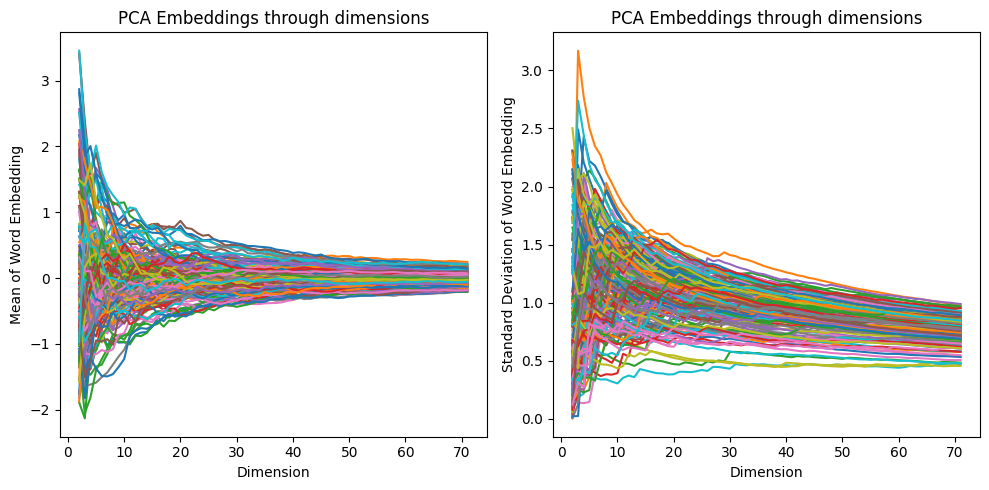

In [109]:
s = []
m = []
for word in embeddings.keys():
    m2 = []
    s2 = []
    for i in range(2,72):
        m2.append(embeddings[word]['SBERT_pca_'+str(i)].mean())
        s2.append(embeddings[word]['SBERT_pca_'+str(i)].std())
    m.append(m2)
    s.append(s2)

plt.figure(figsize=(10, 5))

# Subplot 1: Standard Deviation
plt.subplot(1, 2, 1)
plt.plot(range(2, 72), np.array(m).T)
plt.title("PCA Embeddings through dimensions")
plt.xlabel("Dimension")
plt.ylabel("Mean of Word Embedding")
# Subplot 2: Mean
plt.subplot(1, 2, 2)
plt.plot(range(2, 72), np.array(s).T)
plt.title("PCA Embeddings through dimensions")
plt.xlabel("Dimension")
plt.ylabel("Standard Deviation of Word Embedding")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

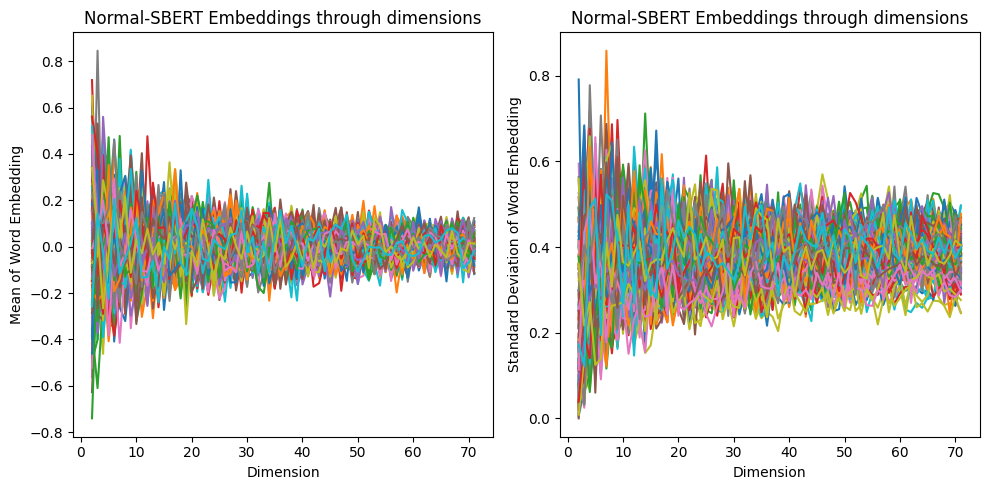

In [108]:
s = []
m = []
for word in embeddings.keys():
    m2 = []
    s2 = []
    for i in range(2,72):
        bert_embbed = embeddings[word]['SBERT']
        mu = bert_embbed.mean()
        sig = bert_embbed.std()
        embedd = np.random.normal(mu, sig, i)
        m2.append(embedd.mean())
        s2.append(embedd.std())
    m.append(m2)
    s.append(s2)

plt.figure(figsize=(10, 5))

# Subplot 1: Standard Deviation
plt.subplot(1, 2, 1)
plt.plot(range(2, 72), np.array(m).T)
plt.title("Normal-SBERT Embeddings through dimensions")
plt.xlabel("Dimension")
plt.ylabel("Mean of Word Embedding")
# Subplot 2: Mean
plt.subplot(1, 2, 2)
plt.plot(range(2, 72), np.array(s).T)
plt.title("Normal-SBERT Embeddings through dimensions")
plt.xlabel("Dimension")
plt.ylabel("Standard Deviation of Word Embedding")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

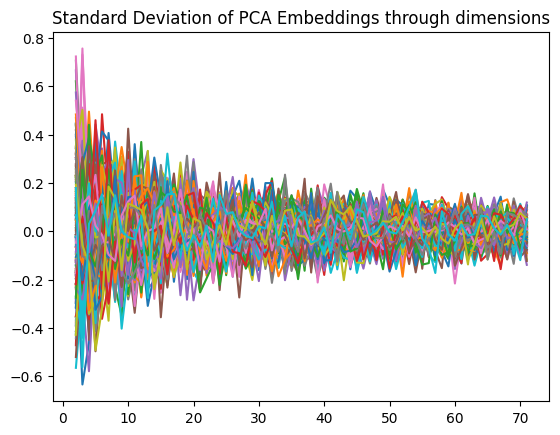

In [104]:
plt.plot(range(2,72), np.array(m).T)
plt.title("Standard Deviation of Normal-SBERT Embeddings through dimensions")
plt.show()

plt.plot(range(2,72), np.array(s).T)
plt.title("Mean of NormalSBERT Embeddings through dimensions")
plt.show()

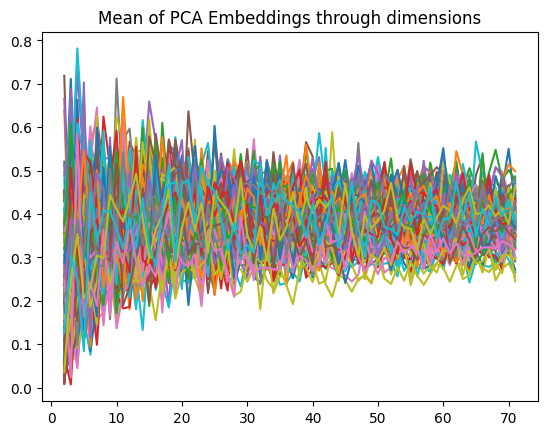

## Word2Vec Embeddings

In [6]:
"""from CustomClasses.Models import W2VModel

dimensions = [10,20,30,40,50,60,70,80,90] + list(np.arange(100,800,100))
window = 5

for vector_dims in dimensions: W2VModel(vector_dims, window, printing=True)

W2V = W2VModel(768, 5)
print("First 10 dims of second word in 768 dims: ")
W2V.getvector(word_list[1])[:10]"""

'from CustomClasses.Models import W2VModel\n\ndimensions = [10,20,30,40,50,60,70,80,90] + list(np.arange(100,800,100))\nwindow = 5\n\nfor vector_dims in dimensions: W2VModel(vector_dims, window, printing=True)\n\nW2V = W2VModel(768, 5)\nprint("First 10 dims of second word in 768 dims: ")\nW2V.getvector(word_list[1])[:10]'

# Models

In [7]:
def assign_encoding_function(type_of_encoding):
    if type_of_encoding == "pca":
        return reduce_by_pca
    elif type_of_encoding == "kpca":
        return reduce_by_kpca
    elif type_of_encoding == "svd":
        return reduce_by_svd
    elif type_of_encoding == "mds":
        return reduce_by_mds
    elif type_of_encoding == "isomap":
        return reduce_by_isomap
    elif type_of_encoding == "tsne":
        return reduce_by_tsne
    elif type_of_encoding == "sammon":
        return reduce_by_sammon
    else:
        raise ValueError(f"Unknown encoding type: {type_of_encoding}")

def get_word_dims(symbols):
    word_dimensions = {}  # Dictionary to store word dimensions
    
    for symbol in symbols:
        parts = symbol.name.split("_")
        word = parts[0]  # Get the word part of the symbol
        max_integer = int(parts[-1]) + 1
        
        if word not in word_dimensions or max_integer > word_dimensions[word]:
            word_dimensions[word] = max_integer
    
    return word_dimensions
    
def check_model_exists_and_load(model_folder_path):
    if os.path.exists(model_folder_path):
        # If the model folder already exists, load the information from the files and return
        model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
        training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
        validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")

        model_params = joblib.load(model_params_filepath)
        training_losses = np.load(training_losses_filepath)
        validation_losses = np.load(validation_losses_filepath)

        return model_params, training_losses, validation_losses, True
    return None, None, None, False

def save_model_training(model_folder_path, model_params, training_losses, validation_losses):
    os.makedirs(model_folder_path, exist_ok=True)

    model_params_filepath = os.path.join(model_folder_path, "model_params.joblib")
    training_losses_filepath = os.path.join(model_folder_path, "training_losses.npy")
    validation_losses_filepath = os.path.join(model_folder_path, "validation_losses.npy")

    joblib.dump(model_params, model_params_filepath)
    np.save(training_losses_filepath, training_losses)
    np.save(validation_losses_filepath, validation_losses)
    return

class QuantumEncodedNumpyModel(NumpyModel):
    def initialize_weights(self):
        if not self.symbols:
            raise ValueError('Symbols not initialized. Instantiate through ''`from_diagrams()`.')
        word_dims = get_word_dims(self.symbols)
        weights_list = []
        for i, symbol in enumerate(self.symbols):
            parts = symbol.name.split("_")
            word = parts[0]  # Get the word part of the symbol
            encoding_method = self.type_of_encoding
            if 'random' in encoding_method:
                weight = random.uniform(-1, 1) * np.pi
            elif "uniform" not in encoding_method and "normal" not in encoding_method:
                weight = embeddings[word].get(encoding_method+"_"+str(word_dims[word]))[int(parts[-1])]
            elif "uniform" in encoding_method:
                #print(encoding_method.split("-"))
                method, value = encoding_method.split("-")
                weight = float(value)
            elif "normal" in encoding_method:
                if "SBERT" in encoding_method:
                    bert_embbed = embeddings[word]['SBERT']
                    mu = bert_embbed.mean()
                    sig = bert_embbed.std()
                    weight = np.random.normal(mu, sig, 1)[0]
                if "zero" in encoding_method:
                    #Normal with mu=0, sigma=1
                    weight = np.random.normal(0, 1, 1)[0]
            weights_list.append(weight/(np.pi))
        self.weights = np.array(weights_list)


def run_quantum_trainer(model_type, ansatz, loss_function, optimizer, optim_hyperparams, num_epochs, batch_size, seed, text='text'):
    noun_count = ansatz.ob_map[Ty('n')]
    sentence_count = ansatz.ob_map[Ty('s')]
    ansatz_hyperparams = {'n': noun_count, 's': sentence_count, 'layers': ansatz.n_layers}

    ansatz_name = ansatz.__class__.__name__.lower()
    loss_name = loss_function.__class__.__name__.lower()
    optimizer_name = optimizer.__name__.lower()
    optimizer_hyperparams_str = '_'.join([f"{key}{val}" for key, val in optim_hyperparams.items()])
    ansatz_hyperparams_str = '_'.join([f"{key}{val}" for key, val in ansatz_hyperparams.items()])

    model_folder = f"{model_type}_{ansatz_name}_{ansatz_hyperparams_str}_{loss_name}_{optimizer_name}_{optimizer_hyperparams_str}_epochs{num_epochs}_batch{batch_size}_seed{seed}"
    model_folder_path = os.path.join("red_dim_models", model_folder)

    model_params, training_losses, validation_losses, dont_proceed_if_model_exists = check_model_exists_and_load(model_folder_path)
    if dont_proceed_if_model_exists is True:
        return model_params, training_losses, validation_losses
    print(model_type, ansatz_name, ansatz_hyperparams_str, ansatz.n_layers, loss_name, optimizer_name, optimizer_hyperparams_str, num_epochs, batch_size, seed)

    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    diagrams, train_dataset, val_dataset = get_datasets(ansatz, seed, batch_size)

    model = QuantumEncodedNumpyModel.from_diagrams(diagrams, use_jit=True)
    model.type_of_encoding = model_type
    model.initialize_weights()

    trainer = QuantumTrainer(
        model,
        loss_function=loss_function,
        epochs=num_epochs,
        optimizer=optimizer,
        optim_hyperparams=optim_hyperparams,
        evaluate_on_train=True,
        verbose=text,
        seed=seed
    )
    trainer.fit(train_dataset, val_dataset, logging_step=1000)

    save_model_training(model_folder_path, model.weights, trainer.train_epoch_costs, trainer.val_costs)

    return model_params, training_losses, validation_losses

In [8]:
ansatz_param_config = {
    '1_1':{AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
    '2_1':{AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
    '1_2':{AtomicType.NOUN: 1, AtomicType.SENTENCE: 2},
    '2_2':{AtomicType.NOUN: 2, AtomicType.SENTENCE: 2},
    }

layer_config = {
    '1':1,
    '2':2,
    '3':3
}

ansatz_config = {
        'IQP': IQPAnsatz,
        'Sim14': Sim14Ansatz,
        'Sim15': Sim15Ansatz,
    }

model_type_config = {
    "random":"random",
    "SBERT_pca": "SBERT_pca",
    "SBERT_kpca": "SBERT_kpca",
    "SBERT_svd":"SBERT_svd",
    "SBERT_mds":"SBERT_mds",
    "SBERT_isomap":"SBERT_isomap",
    #"SBERT_sammon":"SBERT_sammon",
    "SBERT_normal":"SBERT_normal",
    #"W2V_pca": "W2V_pca",
    #"W2V_kpca": "W2V_kpca",
    #"W2V_svd":"W2V_svd",
    #"W2V_mds":"W2V_mds",
    #"W2V_isomap":"W2V_isomap",
    #"W2V_sammon":"W2V_sammon",
    #"W2V_normal":"W2V_normal",
    "uniform-0":"uniform-0",
    "uniform-0.5":"uniform-0.5",
    "uniform-1":"uniform-1",
	"zero_normal":"normal_zero",
}

EPOCHS = 2000
BATCH_SIZE = len(pd.read_csv("Data/TrainingData.txt"))
SEED = 42
for ansatz_name, ansatz_class in ansatz_config.items():
    for ansatz_param_name, ansatz_param in ansatz_param_config.items():
        for layer_name, layer in layer_config.items():
            for model_type in model_type_config.keys():
                ansatz_instance = ansatz_class(ansatz_param, n_layers=layer)
                run_quantum_trainer(model_type, ansatz_instance, MSELoss(), SPSAOptimizer, {'a': 1.0, 'c': 0.01, 'A':0.01*EPOCHS}, EPOCHS, BATCH_SIZE, SEED, "text")

uniform-0 sim14ansatz n1_s1_layers3 3 mseloss spsaoptimizer a1.0_c0.01_A20.0 2000 74 42


c:\Users\henry\Desktop\MastersProject\quantum_env\lib\site-packages\discopy\messages.py:95: UserWarning: Since discopy v0.4.3 the behaviour of permutation has changed. Pass inverse=False to get the default behaviour.
  warnings.warn(message)
Epoch 1:     train/loss: 0.3802   valid/loss: 0.4905
Epoch 1000:  train/loss: 0.0304   valid/loss: 0.1072
Epoch 2000:  train/loss: 0.0031   valid/loss: 0.1162

Training completed!


uniform-0.5 sim14ansatz n1_s1_layers3 3 mseloss spsaoptimizer a1.0_c0.01_A20.0 2000 74 42


Epoch 1:     train/loss: 0.1207   valid/loss: 0.0695
Epoch 1000:  train/loss: 0.0422   valid/loss: 0.1098
Epoch 2000:  train/loss: 0.0032   valid/loss: 0.1262

Training completed!


uniform-1 sim14ansatz n1_s1_layers3 3 mseloss spsaoptimizer a1.0_c0.01_A20.0 2000 74 42


Epoch 1:     train/loss: 0.1756   valid/loss: 0.1140
